In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/ruyogagp/medical_interpretability')

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from cga import cga
import pandas as pd
import neptune.new as neptune
import wandb
import pytorch_lightning as pl
import torch.nn as nn
import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from captum.attr import *
from captum.metrics import *
from captum._utils.models.linear_model import SkLearnLinearRegression
import shap_fork as shap
from source.tasks import DeepSurv
from source.wrappers import ForwardWrapper

In [3]:
results_directory = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/correlation_case'
data_directory = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/correlation'

## Helper Functions

In [4]:
def df2csv(
        df: pd.DataFrame,
        name: str,
        output_dir: str,
):
    """
    Writes csv given a dataframe + name
    """
    train, valid = train_test_split(df, test_size=0.3)
    train.to_csv(
        f"{output_dir}/{name}_train_details.csv",
        index=False,
    )
    valid.to_csv(
        f"{output_dir}/{name}_valid_details.csv",
        index=False,
    )

    train_df = train.loc[:, ['x_orig', 'y_orig', 'time', 'event']]
    valid_df = valid.loc[:, ['x_orig', 'y_orig', 'time', 'event']]
    train_df.to_csv(
        f"{output_dir}/{name}_train.csv",
        index=False,
    )
    valid_df.to_csv(
        f"{output_dir}/{name}_valid.csv",
        index=False,
    )

## Load from wandb

In [10]:
experiment_id = 'p-0.75'
attribute_details = pd.read_csv(f'{data_directory}/{experiment_id}_attribute_details.csv')
attribution_names = ["FeaturePermutation",
                     "FeatureAblation",
                     "KernelExplainer",
                     "DeepExplainer",
                     "ShapleyValueSampling",
                     "IntegratedGradients",
                     "InputxGradient",
                     "Lime",
                     "Saliency"]

# get valid runs
api = wandb.Api()
runs =  api.runs('cardiors/interpretability',
                 filters={"$and": [{'tags': f'{experiment_id}'}, {'state': 'finished'}]})

In [6]:
"""
TODO: output_diff
1. load attribute_details & model
2. make numpy array of orig_features & do_features & calculate difference
3. return output_difference between the two models

TODO: change_slope_model
1. calculate resampling_diff from attribute_details & store it there
2. store change_slope in the model dataframe?
3. load up attribution path (attr_x, attr_y)
4. clip outliers
5. calculate absolute difference
"""

'\nTODO: output_diff\n1. load attribute_details & model\n2. make numpy array of orig_features & do_features & calculate difference\n3. return output_difference between the two models\n\nTODO: change_slope_model\n1. calculate resampling_diff from attribute_details & store it there\n2. store change_slope in the model dataframe?\n3. load up attribution path (attr_x, attr_y)\n4. clip outliers\n5. calculate absolute difference\n'

In [7]:
# TODO: this works if the second tag is the experiment identifier
def load_details(run):
    simpson_dir = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/simpson'
    correlation_dir = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/correlation'
    dir = correlation_dir if 'correlation_case' in run.tags else simpson_dir
    details_df = pd.read_csv(f'{dir}/{run.tags[1]}_attribute_details.csv')
    return details_df

def output_diff(model, orig_features, resampled_features):
    orig_output, *_ = model(orig_features)
    resampled_output, *_ = model(resampled_features)
    with torch.no_grad():
        diff = torch.sub(orig_output, resampled_output)
    return diff.detach().numpy()

def load_attributions(run, method):
    attr_x = np.genfromtxt(run.config[f'{method}_x_path'], delimiter=',')
    attr_y = np.genfromtxt(run.config[f'{method}_y_path'], delimiter=',')
    return attr_x, attr_y

def calculate_error(details_x, details_y):
    for detail in [details_x, details_y]:
        outlier_cs = np.percentile(detail.change_slope, [0.5, 99.5])
        clipped_cs = np.clip(detail.change_slope.to_numpy(), *outlier_cs)
        detail.loc[:,'change_slope_norm'] = clipped_cs / abs(clipped_cs).max()

        outlier_attr = np.percentile(detail.attribution, [0.5, 99.5])
        clipped_attr = np.clip(detail.attribution.to_numpy(), *outlier_attr)
        detail.loc[:,'attribution_norm'] = clipped_attr / abs(clipped_attr).max()
        detail.loc[:, 'error'] = abs(detail.attribution_norm - detail.change_slope_norm)

In [8]:
def change_slope_singular(run, method):
    details = load_details(run)
    model = DeepSurv.load_from_checkpoint(run.config['checkpoint_path'])
    details_x = details[details['modified_attribute'] == 'noise_x']
    details_y = details[details['modified_attribute'] == 'noise_y']
    attr_x, attr_y = load_attributions(run, method)
    for detail in [details_x, details_y]:
        # get input for model difference
        original_values = torch.Tensor(detail[['x_orig', 'y_orig']].to_numpy(dtype='float32'))
        resampled_values = torch.Tensor(detail[['x_do', 'y_do']].to_numpy(dtype='float32'))
        # get resampling difference based on the modified attribute
        if detail.loc[detail.index.min(), ['modified_attribute']].item() == 'noise_x':
            detail.loc[:, 'resampling_diff'] = original_values[:, 0] - resampled_values[:, 0]
            detail.loc[:, 'attribution'] = attr_x[:, 0]
        elif detail.loc[detail.index.min(), ['modified_attribute']].item() == 'noise_y':
            detail.loc[:, 'resampling_diff'] = original_values[:, 1] - resampled_values[:, 1]
            detail.loc[:, 'attribution'] = attr_y[:, 1]
        else:
            raise Exception

        # calculate change slope
        detail.loc[:, 'model_diff']= output_diff(model, original_values, resampled_values)
        detail.loc[:, 'change_slope'] = detail.model_diff / detail.resampling_diff
    calculate_error(details_x, details_y)

    # save dataframes
    seed = eval(run.config['_content']['experiment'])['datamodule_kwargs']['seed']
    filepath_x = '/'.join(run.config[f'{method}_x_path'].split('/')[0:-1] + ['change_slope', f'x_{method}_{seed}.csv'])
    filepath_y = '/'.join(run.config[f'{method}_x_path'].split('/')[0:-1] + ['change_slope', f'y_{method}_{seed}.csv'])
    details_x.to_csv(filepath_x)
    details_y.to_csv(filepath_y)

    return details_x, details_y

In [11]:
for run in runs:
    deets_x, deets_y = change_slope_singular(run, 'KernelExplainer')

In [ ]:
api = wandb.Api()
run = api.run("cardiors/test/5aayrk2q")

In [ ]:
deets_x, deets_y = change_slope_singular(run, 'KernelExplainer')

In [ ]:
deets_y.plot.scatter('x_orig', 'y_orig', c='error', cmap='PuBu')

In [ ]:
deets_x.plot.scatter('x_orig', 'y_orig', c='error', cmap='PuBu')

In [24]:
import os
dir = os.listdir('/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/correlation_case/p-0.75/change_slope/')
change_slope_path = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/results/interpretability/correlation_case/p-0.75/change_slope/'

In [13]:
dir[0]

'x_KernelExplainer_327.csv'

In [48]:
method = 'KernelExplainer'
valid_attr_x = []
valid_attr_y = []
for attr in dir:
    dim = attr.split('_')[0]
    name = attr.split('_')[1]
    seed = attr.split('_')[2]
    if dim == 'x' and name == method:
        valid_attr_x.append(pd.read_csv(f'{change_slope_path}/{attr}', index_col=0))
    elif dim == 'y' and name == method:
        valid_attr_y.append(pd.read_csv(f'{change_slope_path}/{attr}', index_col=0))
    else: print(attr)

err_x = None
err_y = None
for attr in valid_attr_x:
    error_x = attr['error'].to_numpy().reshape(-1, 1)
    err_x = error_x if err_x is None else np.concatenate((err_x, error_x), axis=1)

for attr in valid_attr_y:
    error_y = attr['error'].to_numpy().reshape(-1, 1)
    err_y = error_y if err_y is None else np.concatenate((err_y, error_y), axis=1)

x_FeatureAblation_312.csv
x_FeaturePermutation_312.csv
y_FeatureAblation_312.csv
x_Lime_312.csv
y_FeaturePermutation_312.csv
y_Lime_312.csv


In [57]:
mean_error_x = np.mean(err_x, axis=1)
mean_error_y = np.mean(err_y, axis=1)
deets_x.loc[:, 'mean_error'] = mean_error_x
deets_y.loc[:, 'mean_error'] = mean_error_y

<AxesSubplot:xlabel='x_orig', ylabel='y_orig'>

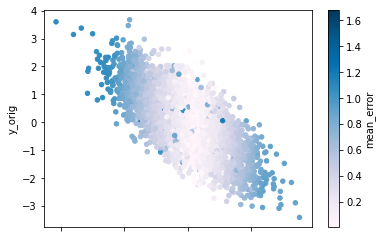

In [58]:
deets_x.plot.scatter('x_orig', 'y_orig', c='mean_error', cmap='PuBu')

<AxesSubplot:xlabel='x_orig', ylabel='y_orig'>

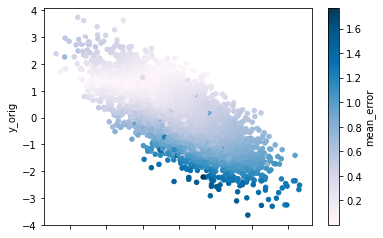

In [59]:
deets_y.plot.scatter('x_orig', 'y_orig', c='mean_error', cmap='PuBu')